In [1]:
from ipycanvas import Canvas
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.abspath(os.path.join('../src/'))

if src_path not in sys.path:
    sys.path.append(src_path)

from bandUtils import Band
from convNetUtils import predict_on_raster, predict_label_category_on_raster
from labelsUtils import Label, LabelCategory
from visualizationUtils import label_first_detections
from regionUtils import vietnam_labels_coordinates

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
DATA_ROOT_PATH = '../data/'
MODEL_ROOT_PATH = '../models/'
IMAGE_SIZE = 9
bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

# Only labels that contains georeferenced points.
labels = [
    Label.COFFEE,
    Label.NATIVEVEGE,
    Label.RUBBER,
    Label.SEASONAL,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    # Label.CASSAVA, # /!\ only 4 images
    Label.TEA,
    Label.RICE,
    Label.INTERCROP,
    Label.DECIDUOUS_FOREST,
    Label.STICK_PEPPER,
    Label.PINE_TREES,
]

categories = [category for category in LabelCategory]

In [3]:
image_width = 9
image_height = 9
image_depth = len(bands)

inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(1./2**16)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = SpatialDropout2D(0.25)(layers)
layers = GlobalAveragePooling2D()(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])
model.summary()
model.load_weights(MODEL_ROOT_PATH + "january_to_april_2018_multi_output_focal_loss.hdf5")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 32)     2048        batch_normalization[0][0]        
______________________________________________________________________________________________

In [4]:
year_label_predictions = []
year_category_predictions = []
year_img_indices = []

for year in range(14, 22):
    print(f"20{year} ...")

    raster_path = DATA_ROOT_PATH + "Vietnam_20{}_january_to_april/merged.tif".format(year)
    label_predictions, category_predictions, img_indices = predict_label_category_on_raster(model, raster_path, bands, IMAGE_SIZE)
    
    year_label_predictions.append(label_predictions)
    year_category_predictions.append(category_predictions)
    year_img_indices.append(img_indices)

2014 ...
Image width: 16709
Image height: 7423
Nb row of images: 1856
Nb col of images: 824
Width is not dividable by 9, some px will be ignored...
Height is not dividable by 9, some px will be ignored...
2015 ...
Image width: 16709
Image height: 7423
Nb row of images: 1856
Nb col of images: 824
Width is not dividable by 9, some px will be ignored...
Height is not dividable by 9, some px will be ignored...
2016 ...
Image width: 16709
Image height: 7423
Nb row of images: 1856
Nb col of images: 824
Width is not dividable by 9, some px will be ignored...
Height is not dividable by 9, some px will be ignored...
2017 ...
Image width: 16709
Image height: 7423
Nb row of images: 1856
Nb col of images: 824
Width is not dividable by 9, some px will be ignored...
Height is not dividable by 9, some px will be ignored...
2018 ...
Image width: 16709
Image height: 7423
Nb row of images: 1856
Nb col of images: 824
Width is not dividable by 9, some px will be ignored...
Height is not dividable by 9, so

In [10]:
row_indices = [
    [indices[0] for indices in year_img_indices[year]]
    for year in range(len(year_label_predictions))
]

col_indices = [
    [indices[1] for indices in year_img_indices[year]]
    for year in range(len(year_label_predictions))
] 

df_list = [
    pd.DataFrame(data=dict({
        'image row': row_indices[year - 14],
        'image col': col_indices[year - 14],
        'label_predicted': year_label_predictions[year - 14],
        'category_predicted': year_category_predictions[year - 14]
    })).assign(year=int("20" + str(year)))
    for year in range(14, 22)
]

# Concatenate all those dataframe into one
concat_df = pd.concat(df_list)

In [11]:
concat_df.to_csv(os.path.join(DATA_ROOT_PATH, 'predictions_january_to_april_2014_2021.csv'), index=False)

In [4]:
concat_df = pd.read_csv(os.path.join(DATA_ROOT_PATH, 'predictions_january_to_april_2014_2021.csv'))

In [5]:
concat_df

,image row,image col,label_predicted,category_predicted,year
0,0,358,1,1,2014
1,0,359,1,1,2014
2,0,360,1,1,2014
3,0,361,1,1,2014
4,0,362,1,1,2014
...,...,...,...,...,...
9581157,1855,253,0,0,2021
9581158,1855,254,0,0,2021
9581159,1855,255,2,0,2021
9581160,1855,256,2,0,2021


In [6]:
total_per_year_df = concat_df.groupby('year').agg(count=pd.NamedAgg(column='label_predicted', aggfunc='value_counts')).reset_index()

In [7]:
total_per_year_df

,year,label_predicted,count
0,2014,1,393372
1,2014,0,251779
2,2014,2,133031
3,2014,10,104559
4,2014,8,60390
...,...,...,...
115,2021,12,32355
116,2021,7,9686
117,2021,9,7228
118,2021,11,638


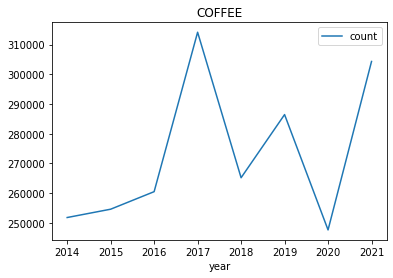

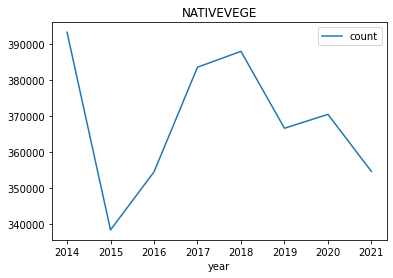

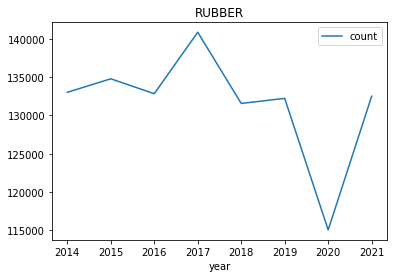

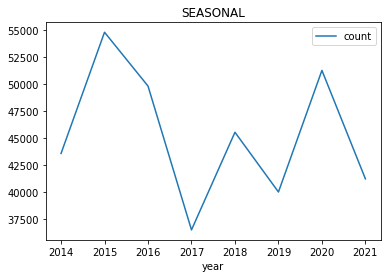

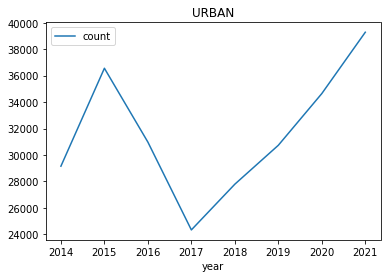

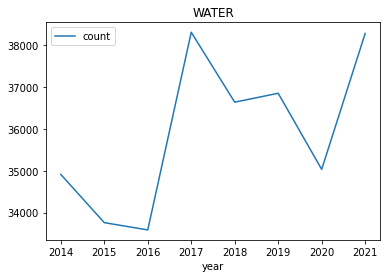

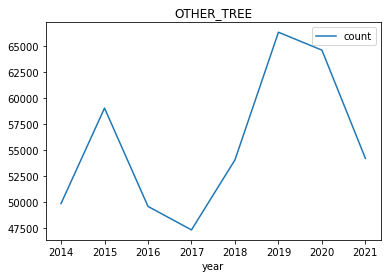

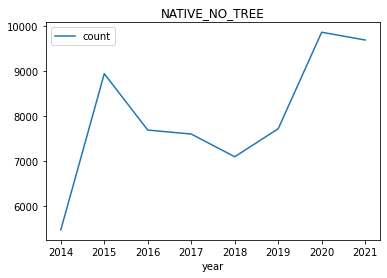

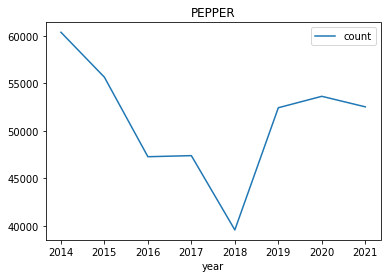

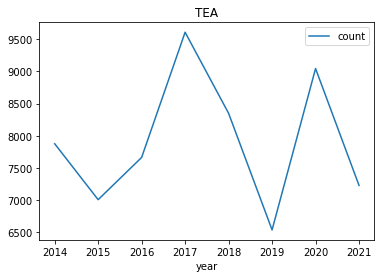

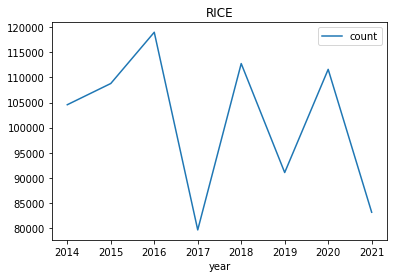

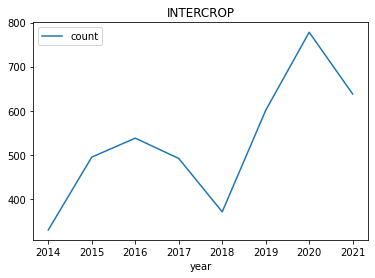

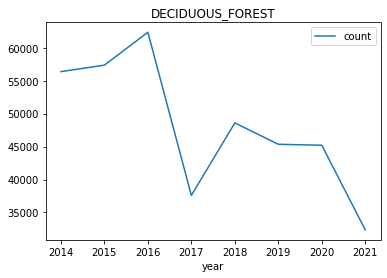

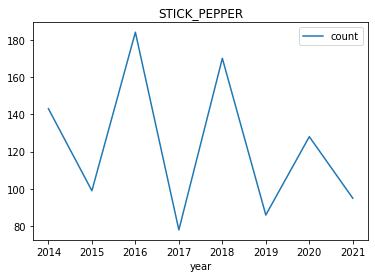

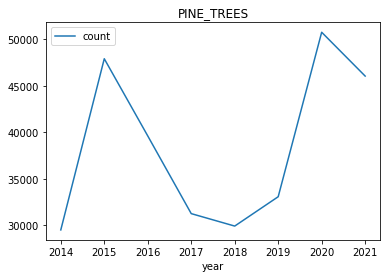

In [8]:
for label in labels:
    total_per_year_df[total_per_year_df['label_predicted']==labels.index(label)][['count', 'year']].plot(x="year", title=label.name)

In [9]:
concat_df = pd.read_csv(os.path.join(DATA_ROOT_PATH, 'predictions_january_to_april_2014_2021.csv'))
year_2014_df = concat_df[concat_df['year']==2014]
coffee_points = year_2014_df[year_2014_df['label_predicted']==labels.index(Label.COFFEE)]
coffee_points_x = coffee_points['image col'].to_list()
coffee_points_y = coffee_points['image row'].to_list()

other_points = year_2014_df[year_2014_df['label_predicted']!=labels.index(Label.COFFEE)]
other_points_x = other_points['image col'].to_list()
other_points_y = other_points['image row'].to_list()

# display_map_from_dataframe(year_2014_df)

In [10]:
canvas = Canvas(width=823, height=1856)

canvas.clear()

canvas.fill_style = 'green'
canvas.fill_rects(coffee_points_x, coffee_points_y, 1)

canvas.fill_style = 'black'
canvas.fill_rects(other_points_x, other_points_y, 1)

canvas

Canvas(height=1856, width=823)

In [11]:
LABELS_COORDINATES = vietnam_labels_coordinates()

In [12]:
row_col_coffee_labels = []

with rasterio.open(DATA_ROOT_PATH + 'Vietnam_2017_january_to_april/merged.tif') as raster:
    row_col_coffee_labels = [raster.index(coord[0], coord[1], precision=23) for coord in LABELS_COORDINATES[Label.COFFEE.value]]

In [13]:
x_coffee = [row_col[1] / 9 for row_col in row_col_coffee_labels]
y_coffee = [row_col[0] / 9 for row_col in row_col_coffee_labels]

In [14]:
canvas.fill_style = 'red'
canvas.fill_rects(x_coffee, y_coffee, 1)

In [15]:
canvas = Canvas(width=823, height=1856)
canvas

Canvas(height=1856, width=823)

In [16]:
canvas.clear()
canvas.width = 823
canvas.height = 1856
canvas.layout.width = str(canvas.width * 1) + "px"
canvas.layout.height = str(canvas.height * 1) + "px"
canvas.fill_style = 'black'
canvas.fill_rects(other_points_x, other_points_y, 1)

coffee_first_detections = label_first_detections(
    DATA_ROOT_PATH + 'Vietnam_2017_january_to_april/merged.tif',
    concat_df,
    labels.index(Label.COFFEE),
    LABELS_COORDINATES[Label.COFFEE.value]
)

canvas.fill_style = 'white'
canvas.fill_rects(coffee_points_x, coffee_points_y, 1)

coffe_first_detections = pd.DataFrame(coffee_first_detections, columns=['row', 'col', 'year'])
row_col = coffe_first_detections[(coffe_first_detections.year == 'nan')][['row', 'col']]
x = row_col.col.to_list()
y = row_col.row.to_list()

canvas.fill_style = 'silver'
canvas.fill_rects(x, y, 1)

coffe_first_detections = pd.DataFrame(coffee_first_detections, columns=['row', 'col', 'year'])
row_col = coffe_first_detections[(coffe_first_detections.year == 2014)][['row', 'col']]
x = row_col.col.to_list()
y = row_col.row.to_list()

canvas.fill_style = 'yellow'
canvas.fill_rects(x, y, 1)

row_col = coffe_first_detections[(coffe_first_detections.year == 2015)][['row', 'col']]
x = row_col.col.to_list()
y = row_col.row.to_list()

canvas.fill_style = 'olive'
canvas.fill_rects(x, y, 1)

row_col = coffe_first_detections[(coffe_first_detections.year == 2016)][['row', 'col']]
x = row_col.col.to_list()
y = row_col.row.to_list()

canvas.fill_style = 'lime'
canvas.fill_rects(x, y, 1)

row_col = coffe_first_detections[(coffe_first_detections.year == 2017)][['row', 'col']]
x = row_col.col.to_list()
y = row_col.row.to_list()

canvas.fill_style = 'green'
canvas.fill_rects(x, y, 1)

row_col = coffe_first_detections[(coffe_first_detections.year == 2018)][['row', 'col']]
x = row_col.col.to_list()
y = row_col.row.to_list()

canvas.fill_style = 'fuchsia'
canvas.fill_rects(x, y, 1)

row_col = coffe_first_detections[(coffe_first_detections.year == 2019)][['row', 'col']]
x = row_col.col.to_list()
y = row_col.row.to_list()

canvas.fill_style = 'purple'
canvas.fill_rects(x, y, 1)

row_col = coffe_first_detections[(coffe_first_detections.year == 2020)][['row', 'col']]
x = row_col.col.to_list()
y = row_col.row.to_list()

canvas.fill_style = 'red'
canvas.fill_rects(x, y, 1)

row_col = coffe_first_detections[(coffe_first_detections.year == 2021)][['row', 'col']]
x = row_col.col.to_list()
y = row_col.row.to_list()

canvas.fill_style = 'maroon'
canvas.fill_rects(x, y, 1)